## Named Entity Recognition (NER) and Bidirectional LSTM

**Named Entity Recognition (NER)** is a natural language processing (NLP) task that involves identifying and classifying entities in text into predefined categories, such as:
- Person names (e.g., "John Doe")
- Organizations (e.g., "OpenAI")
- Locations (e.g., "New York")
- Dates and time (e.g., "January 1, 2023")

### NER with Bidirectional LSTM

A Bidirectional Long Short-Term Memory (BiLSTM) network is an effective architecture for NER because it considers the context of words in both forward and backward directions. This enables the model to capture dependencies from both preceding and succeeding words in the sequence, which is crucial for understanding context in text.

#### Key Components:
1. **Input Representation**: Words are represented as word embeddings, such as Word2Vec, GloVe, or contextual embeddings like BERT.
2. **Bidirectional LSTM**: Processes the sequence of embeddings in both forward and backward directions, producing context-aware representations for each word.
3. **Output Layer**: A dense layer followed by a softmax activation is used to classify each word into its respective entity class.

#### Mathematical Explanation

Let $ x_t $ be the embedding of the word at position $ t $ in a sequence of length $ T $.

1. **Forward LSTM**:
   The hidden state at time $ t $ is computed as:
   $$
   \overrightarrow{h_t} = \text{LSTM}(x_t, \overrightarrow{h_{t-1}})
  $$
2. **Backward LSTM**:
   Similarly, the hidden state for the backward LSTM is:
   $$
   \overleftarrow{h_t} = \text{LSTM}(x_t, \overleftarrow{h_{t+1}})
  $$
3. **Concatenation**:
   The final hidden state for each word combines both directions:
   $$
   h_t = \text{concat}(\overrightarrow{h_t}, \overleftarrow{h_t})
  $$

4. **Classification**:
   The output for each word is computed by applying a dense layer with softmax activation:
   $$
   y_t = \text{softmax}(W \cdot h_t + b)
  $$
   where $ W $ and $ b $ are trainable parameters, and $ y_t $ represents the probabilities for each entity class.

#### Workflow:
1. Preprocess the text and tokenize it.
2. Convert tokens into embeddings.
3. Pass embeddings through the BiLSTM.
4. Use the output states for each token to predict entity classes.

By training the BiLSTM model on annotated datasets (e.g., CoNLL-2003), the model learns to effectively recognize entities in text based on context.


## CoNLL-2003
The **CoNLL-2003 dataset** is one of the most widely used datasets for Named Entity Recognition (NER). It was introduced as part of the Conference on Natural Language Learning (CoNLL) shared task in 2003. This dataset is annotated for four types of entities:

1. **PER**: Person names
2. **ORG**: Organizations
3. **LOC**: Locations
4. **MISC**: Miscellaneous entities that do not fit into the other categories

### Dataset Structure
The dataset consists of text data in multiple languages (e.g., English, German), but the English portion is most commonly used. It contains:
- **Tokens**: Words from sentences.
- **Part-of-Speech (POS) tags**: POS tags for each word.
- **Chunk tags**: Information about syntactic chunks.
- **NER labels**: Entity labels in the BIO format (Begin-Inside-Outside).

#### Example:
| Token   | POS   | Chunk   | NER   |
|---------|-------|---------|-------|
| EU      | NNP   | I-NP    | B-ORG |
| rejects | VBZ   | I-VP    | O     |
| German  | JJ    | I-NP    | B-MISC|
| call    | NN    | I-NP    | O     |
| to      | TO    | I-VP    | O     |
| boycott | VB    | I-VP    | O     |
| British | JJ    | I-NP    | B-MISC|
| lamb    | NN    | I-NP    | O     |
| .       | .     | O       | O     |

### BIO Format
The dataset uses the **BIO tagging scheme**:
- **B**: Beginning of an entity.
- **I**: Inside an entity.
- **O**: Outside of any entity.



In [1]:
#!pip install datasets

In [2]:
import datasets
data= datasets.load_dataset('eriktks/conll2003')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:

ner_idx={'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

train_data, test_data, validation_data= data['train'], data['test'],data['validation']

In [4]:
import numpy as np
from collections import Counter

train_tokens=[token.lower() for sample in train_data for token in sample['tokens']]
vocab=Counter(train_tokens)
vocab['<pad>']=1


In [5]:
sent_lengths=[len(sample['tokens']) for sample in train_data ]

np.min(sent_lengths),np.mean(sent_lengths),np.max(sent_lengths)

(1, 14.501887329962253, 113)

### 1. Dataset and Dataloader Creation

In [6]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, train_data, vocab, ner_idx, max_length=128):

        self.train_data = train_data
        self. max_length= max_length
        self.w2i={k:i for i, (k,v) in enumerate(vocab.items())}
        self.i2w={v:k for (k,v) in enumerate(self.w2i.items())}

        self.ner_idx=ner_idx
        self.idx_ner={ v:k for (k,v) in self.ner_idx.items()}
    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
         sample=train_data[idx]

         idxs=[self.w2i[token.lower()] for token in sample['tokens']]
         ner_tags=sample['ner_tags']

         ner_tags_padded=np.zeros(self.max_length )
         ner_tags_padded[:len(ner_tags)]=ner_tags

         idxs_padded=np.ones(self.max_length )*self.w2i['<pad>']
         idxs_padded[:len(ner_tags)]=idxs
         return idxs_padded.astype('int32'), ner_tags_padded



In [7]:
train_dataset= CustomDataset(train_data, vocab, ner_idx, max_length=np.max(sent_lengths))
test_dataset= CustomDataset(test_data, vocab, ner_idx, max_length=np.max(sent_lengths))

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


### 2. Model Creation

We use a Bidirectional LSTM (BiLSTM) model with a CRF layer or a Transformer-based model like BERT for NER.

In [9]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers, dropout_rate, output_dim):
        super(TinyModel, self).__init__()

        self.embedding= torch.nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = torch.nn.LSTM( embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout_rate,  bidirectional=True, batch_first=True)
        self.linear1 = torch.nn.Linear(2* hidden_size, output_dim)


    def forward(self, x):

        x = self.embedding(x)
        x,(hn,cn) = self.lstm(x)
        x = self.linear1(x)

        return x


In [10]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_embeddings=len(vocab)
embedding_dim= 300
hidden_size = 256
num_layers =3
dropout_rate=0.25
output_dim=len(ner_idx)

model = TinyModel(num_embeddings, embedding_dim, hidden_size, num_layers, dropout_rate, output_dim).to(device)


In [11]:

optimizer= torch.optim.Adam(model.parameters())

loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

### 3. Training Loop

The training loop involves forward propagation, loss computation, and backpropagation. Use `CrossEntropyLoss` for classification tasks.

In [12]:
from tqdm import tqdm
n_epochs=10
train_loss=[]
test_loss=[]

best_test_loss=np.inf
for epoch in range(n_epochs):
  model.train()
  running_loss=[]
  for batch in tqdm(train_dataloader):

    inputs, targets= batch

    inputs, targets= inputs.to(device).long(), targets.to(device).long().reshape(-1)

    mask=(inputs.reshape(-1)!=train_dataset.w2i['<pad>'])

    optimizer.zero_grad()
    outputs= model(inputs).reshape(-1, output_dim)
    loss=torch.sum(loss_fn(outputs,targets )*mask)/torch.sum(mask)
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())
  train_loss.append(np.mean(running_loss))
  print('Train Epoch {} Loss  {}'.format(epoch, train_loss[-1]))
  model.eval()
  running_loss=[]
  for batch in tqdm(test_dataloader):

    inputs, targets= batch

    inputs, targets= inputs.to(device).long(), targets.to(device).long().reshape(-1)

    mask=(inputs.reshape(-1)!=train_dataset.w2i['<pad>'])

    with torch.no_grad():
      outputs= model(inputs).reshape(-1, output_dim)
    loss=torch.sum(loss_fn(outputs,targets )*mask)/torch.sum(mask)
    running_loss.append(loss.item())

  test_loss.append(np.mean(running_loss))
  print('Test Epoch {} Loss  {}'.format(epoch, test_loss[-1]))

  if test_loss[-1] < best_test_loss:
    best_test_loss=test_loss[-1]
    torch.save(model.state_dict(),'best_model.pth')

100%|██████████| 220/220 [00:19<00:00, 11.58it/s]


Train Epoch 0 Loss  0.5060301599177447


100%|██████████| 54/54 [00:01<00:00, 27.82it/s]


Test Epoch 0 Loss  0.18800431986649832


100%|██████████| 220/220 [00:18<00:00, 11.86it/s]


Train Epoch 1 Loss  0.14990165137093175


100%|██████████| 54/54 [00:01<00:00, 29.33it/s]


Test Epoch 1 Loss  0.06364694503308446


100%|██████████| 220/220 [00:19<00:00, 11.43it/s]


Train Epoch 2 Loss  0.06425425967370922


100%|██████████| 54/54 [00:01<00:00, 29.15it/s]


Test Epoch 2 Loss  0.029923102749442612


100%|██████████| 220/220 [00:18<00:00, 11.60it/s]


Train Epoch 3 Loss  0.030388006678020413


100%|██████████| 54/54 [00:01<00:00, 27.41it/s]


Test Epoch 3 Loss  0.013439030386507511


100%|██████████| 220/220 [00:18<00:00, 11.68it/s]


Train Epoch 4 Loss  0.017034032619134946


100%|██████████| 54/54 [00:01<00:00, 29.57it/s]


Test Epoch 4 Loss  0.008879449779029798


100%|██████████| 220/220 [00:18<00:00, 11.61it/s]


Train Epoch 5 Loss  0.012619216278174215


100%|██████████| 54/54 [00:01<00:00, 29.26it/s]


Test Epoch 5 Loss  0.005821500620287325


100%|██████████| 220/220 [00:18<00:00, 11.73it/s]


Train Epoch 6 Loss  0.008921975876860829


100%|██████████| 54/54 [00:01<00:00, 28.19it/s]


Test Epoch 6 Loss  0.005159369421933123


100%|██████████| 220/220 [00:18<00:00, 11.64it/s]


Train Epoch 7 Loss  0.0073117122109661896


100%|██████████| 54/54 [00:01<00:00, 29.27it/s]


Test Epoch 7 Loss  0.004243854202084347


100%|██████████| 220/220 [00:18<00:00, 11.60it/s]


Train Epoch 8 Loss  0.006388760895193131


100%|██████████| 54/54 [00:01<00:00, 28.83it/s]


Test Epoch 8 Loss  0.0041022900463926985


100%|██████████| 220/220 [00:18<00:00, 11.73it/s]


Train Epoch 9 Loss  0.005114065671064468


100%|██████████| 54/54 [00:01<00:00, 28.87it/s]


Test Epoch 9 Loss  0.0025302674430012877


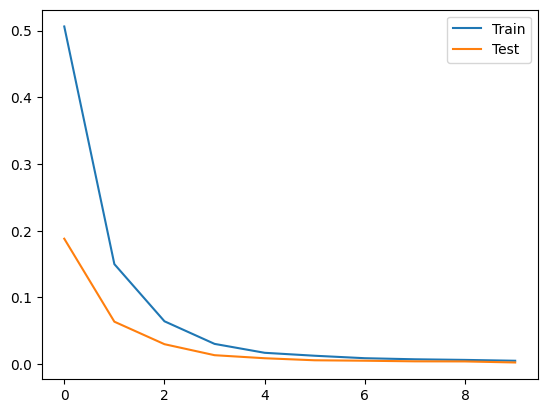

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()

### 4. Evaluation Process

Evaluate the model on the test set using metrics like accuracy, precision, recall, and F1-score.


In [21]:
y_true, y_pred=[],[]
model.eval()

for batch in tqdm(test_dataloader):

    inputs, targets= batch

    inputs, targets= inputs.to(device).long(), targets.numpy().reshape(-1)

    mask=(inputs.reshape(-1)!=train_dataset.w2i['<pad>']).cpu().numpy()
    with torch.no_grad():
      outputs= np.argmax(model(inputs).reshape(-1, output_dim).detach().cpu().numpy(), 1)
    y_true.extend(targets[mask])
    y_pred.extend( outputs[mask])


100%|██████████| 54/54 [00:02<00:00, 24.73it/s]


In [24]:
y_true[:10]

[0.0, 0.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 0.0, 0.0]

In [27]:
np.mean(np.array(y_pred)== np.array(y_true))

0.9992694821220557

In [28]:
from sklearn.metrics import classification_report
target_names = ner_idx.keys()
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           O       1.00      1.00      1.00     41744
       B-PER       1.00      1.00      1.00      1806
       I-PER       1.00      1.00      1.00      1358
       B-ORG       1.00      1.00      1.00      1237
       I-ORG       1.00      0.99      0.99       812
       B-LOC       1.00      1.00      1.00      2128
       I-LOC       1.00      1.00      1.00       279
      B-MISC       0.99      1.00      0.99       952
      I-MISC       1.00      1.00      1.00       333

    accuracy                           1.00     50649
   macro avg       1.00      1.00      1.00     50649
weighted avg       1.00      1.00      1.00     50649



In [29]:
sample=test_data[0]

In [60]:
tokens=sample['tokens']
gt=sample['ner_tags']

In [61]:
list(zip(tokens,gt))

[('SOCCER', 0),
 ('-', 0),
 ('JAPAN', 5),
 ('GET', 0),
 ('LUCKY', 0),
 ('WIN', 0),
 (',', 0),
 ('CHINA', 1),
 ('IN', 0),
 ('SURPRISE', 0),
 ('DEFEAT', 0),
 ('.', 0)]

In [84]:
idxs=[train_dataset.w2i[token.lower()] for token in tokens]

In [85]:
idxs

[1754, 635, 1672, 1992, 6417, 2301, 68, 340, 228, 3800, 3773, 8]

In [90]:
inputs=np.ones(113)*train_dataset.w2i['<pad>']
inputs[:len(idxs)]=idxs

In [91]:
inputs=torch.from_numpy(inputs).unsqueeze(0).to(device).long()

In [92]:
inputs.shape

torch.Size([1, 113])

In [93]:
with torch.no_grad():
      outputs= torch.nn.functional.softmax(model(inputs),-1).detach().cpu().numpy()[:,:len(idxs)]

In [94]:
outputs.shape

(1, 12, 9)

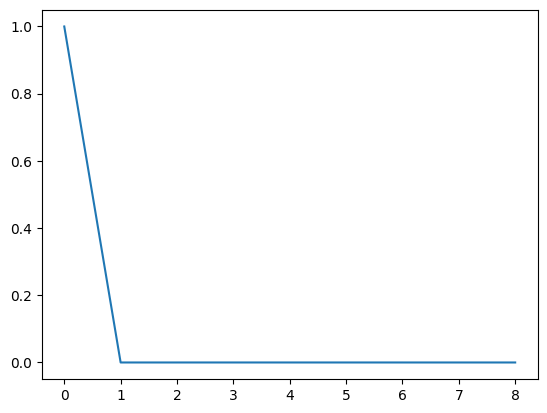

In [95]:
plt.plot(outputs[0][0])

In [96]:
outputs.shape

(1, 12, 9)

In [97]:
np.argmax(outputs, -1), gt

(array([[0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0]]),
 [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [69]:
train_dataset.idx_ner

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [73]:
[train_dataset.idx_ner[idx] for idx in list(np.argmax(outputs, -1))[0]]

['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']

In [63]:
np.mean(np.argmax(outputs, -1)==np.array(gt))

0.9166666666666666

In [64]:
1/12

0.08333333333333333